In [2]:
# Basic test of QuTiP functionality
# would like to keep namespace in general; but for ease of following tutorial, will use from qutip import * for now
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

# make and manipulate basic qubit
spin_down = basis(2,0)
spin_up = sigmax() * spin_down
#print(spin_up)
#print(spin_down)

Text(0.5, 0, 'Time')

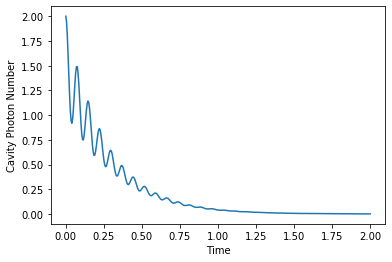

In [3]:
# Try some basic Jaynes-Cummings stuff
# First example: decay and exchange of 'phot_init' photons between cavity and atom
# parameters
g=30
kappa = 1.4
gamma = 6
cav_exc_max = 5
prb = 0.0
phot_init = 2 # initial photon number

# Hilbert space [cavity, qubit]
# some initial ground states
cav0 = basis(cav_exc_max, n=phot_init)
qubit0 = sigmam()*basis(2, 0) # ground state qubit
psi0 = tensor([cav0, qubit0])
# useful operators
a = tensor(destroy(cav_exc_max), qeye(2)) # cavity annihilation
drive = (a.dag() + a)
qubit_excitations = tensor(qeye(cav_exc_max), (sigmaz()+1)/2) 

exchange = (tensor(create(cav_exc_max), sigmam()));
exchange = exchange+exchange.dag();

# Hamiltonian
H = prb*drive + g*exchange 
# list of collapse operators [cavity decay, atomic decay]
c = [np.sqrt(kappa)*tensor(destroy(cav_exc_max), qeye(2)), np.sqrt(gamma)*tensor(qeye(cav_exc_max), sigmam())]

times = np.linspace(0.0, 2.0, 400)
result = mesolve(H, psi0, times, c, [a.dag()*a])

fig, ax = plt.subplots()
ax.plot(times, result.expect[0])
plt.ylabel('Cavity Photon Number')
plt.xlabel('Time')


/home/dawit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


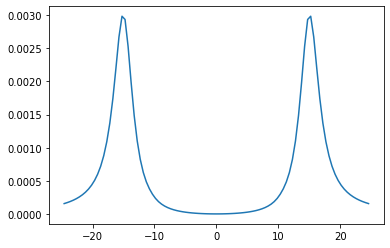

In [5]:
# VRS spectrum, assuming cav and qubit degenerate
# parameters
g=15
kappa = 1.4
gamma = 6
prb = 0.2
npts = 101

nphot = np.empty(npts)
deltas = np.linspace(1.5*(-g-kappa), 1.5*(g+kappa), npts)
for i, delta in enumerate(deltas, start=0):
    # Hamiltonian
    H = prb*drive + g*exchange + delta*(a.dag()*a + qubit_excitations) # detune probe from excitations
    # list of collapse operators [cavity decay, atomic decay]
    c = [np.sqrt(kappa)*tensor(destroy(cav_exc_max), qeye(2)), 
         np.sqrt(gamma)*tensor(qeye(cav_exc_max), sigmam())]
    
    rho_ss = steadystate(H, c, method='direct')
    
    nphot[i] = np.trace(a.dag()*a*rho_ss) # expected intracavity photon number
    
    
fig=plt.figure()
plt.plot(deltas, nphot)   

C:\Users\Logan\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'g=150 | $\\kappa$=1.4 | $\\Gamma$=3 | PrbPwr=0.1')

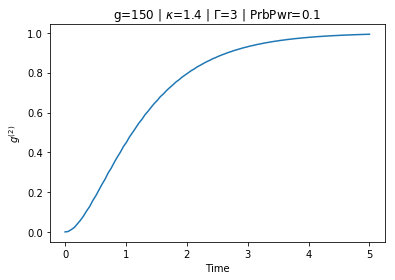

In [117]:
# g2: "probe" on VRS peak, look for g2 suppression

max_time = 5.0
time_steps = 100
# probe on VRS peak:
g=150
kappa = 1.4
gamma = 3
prb = 0.1
npts = 101
delta = g

# array of times for calculating evolution after a photon was detected
times = np.linspace(0.0, max_time, time_steps)

H = prb*drive + g*exchange + delta*(a.dag()*a + qubit_excitations) # detune probe from excitations
# list of collapse operators [cavity decay, atomic decay]
c = [np.sqrt(kappa)*tensor(destroy(cav_exc_max), qeye(2)), 
     np.sqrt(gamma)*tensor(qeye(cav_exc_max), sigmam())]

# prepare options for mesolver to not tidy up small values
options = Options(tidy=False)

# calculate steady state
rho_ss = steadystate(H, c, method='direct')

# calculate time evolution after removing a photon from steady state
rho_m1 = a * rho_ss * a.dag()
norm = np.trace(rho_m1)
rho_m1 = a * (rho_ss / norm) * a.dag()
rho_m1_t = mesolve(H, rho_m1, times, c, [a.dag()*a], options=options)


# build g2
num = rho_m1_t.expect[0] * norm 
den = np.power(np.trace(a.dag()*a*rho_ss), 2)
g2 = num/den

# matplotlib
fig=plt.figure()
plt.plot(times, g2)   
plt.xlabel('Time')
plt.ylabel('$g^{(2)}$')
plt.title('g='+str(g) + ' | $\kappa$=' + str(kappa) + ' | $\Gamma$=' + str(gamma) + ' | PrbPwr=' + str(prb))

C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5,0,'$\\eta$')

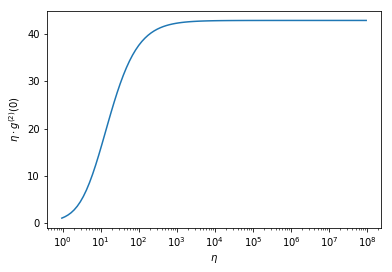

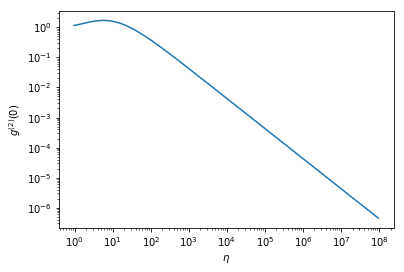

In [137]:
# What is g2(0) as a function of the cooperativity?
# g2: "probe" on VRS peak, look for g2 suppression
# probe on VRS peak:
gexp = np.linspace(0.0, 4.0, 100)
g=10**gexp
kappa = 1.4
gamma = 3
prb = 0.2
delta = g

# array of times for calculating evolution after a photon was detected
times = np.linspace(0.0, max_time, time_steps)

g2 = 0*g
for i, thisg in enumerate(g):
    H = prb*drive + thisg*exchange + delta[i]*(a.dag()*a + qubit_excitations) # detune probe from excitations
    # list of collapse operators [cavity decay, atomic decay]
    c = [np.sqrt(kappa)*tensor(destroy(cav_exc_max), qeye(2)), 
         np.sqrt(gamma)*tensor(qeye(cav_exc_max), sigmam())]
    
    # calculate steady state
    rho_ss = steadystate(H, c, method='direct')
    # calculate g2(0)
    rho_m1 = a * rho_ss * a.dag()
    norm = np.trace(rho_m1)
    rho_m1 = a * (rho_ss / norm) * a.dag()
    num = np.trace(a.dag()*a*(rho_m1 * norm))
    den = np.power(np.trace(a.dag()*a*rho_ss), 2)
    g2[i] = num/den

fig10 = plt.figure()
eta = 4*g**2/kappa/gamma
plt.semilogx(eta, g2*eta)
plt.ylabel('$\eta \cdot g^{(2)}(0)$')
plt.xlabel('$\eta$')

fig20 = plt.figure()
eta = 4*g**2/kappa/gamma
plt.loglog(eta, g2)
plt.ylabel('$g^{(2)}(0)$')
plt.xlabel('$\eta$')

